# HW 7

In [1]:
# imports here
import pandas as pd
import numpy as np

#viz
import seaborn as sns
import matplotlib.pyplot as plt

# progress bar
from tqdm import tqdm

In [2]:

from google.colab import drive
ROOT_DIR = '/content/drive' 
drive.mount(ROOT_DIR)

Mounted at /content/drive


## Обработка данных

In [3]:
! cp /content/drive/MyDrive/ml_2023/reviews.zip  /content/
! unzip /content/reviews.zip

Archive:  /content/reviews.zip
  inflating: winemag-data-130k-v2.csv  
  inflating: winemag-data-130k-v2.json  
  inflating: winemag-data_first150k.csv  


Датасет содежит данные о раздичных экземплярахх вин. Информацию о стране производства, его оценка, цена, описание, название, сорт и т.д.

Все данные нужно разделить на подгруппы - произвести кластеризацию.

In [4]:
data = pd.read_csv('/content/winemag-data-130k-v2.csv', sep=',')
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Для обучения моделей выбраны 4 наиболее информативных признака - страна, оценка, цена и сорт.

In [5]:

df = data[['country', 'points', 'price', 'variety']]

В качетсве предобработки данных нужно заполнить пропуски. В графе сорт только одно пропущенное значение. Можно удалить этот экземпляр. Все пропущенные страны будут заполнены самой популярной - США. И неизвестное значение цены заполним медианой.

In [6]:
df.isnull().sum()

country      63
points        0
price      8996
variety       1
dtype: int64

In [7]:
df = df[~df.variety.isnull()]
df = df[~df.country.isnull()]

In [8]:
df.price.mean()


35.36879626183683

In [9]:
df.price.fillna(value=df.price.mean(), inplace=True)

In [10]:
df.isnull().sum()

country    0
points     0
price      0
variety    0
dtype: int64

Для преобрадования объектных признаков в числовые сделаем LabelEncoder. И для упрощение работы алгоритмов сделаем нормализацию данных.

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df.country = le.fit_transform(df.country)
df.variety = le.fit_transform(df.variety)

In [12]:
len(df)

129907

In [13]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
data_scaled=df.copy()
data_scaled[data_scaled.columns]=std_scaler.fit_transform(data_scaled)

In [14]:
data_scaled.describe()

,country,points,price,variety
count,1.299070e+05,1.299070e+05,1.299070e+05,1.299070e+05
mean,1.242699e-16,1.043167e-15,3.828738e-18,-1.413351e-16
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-2.123346e+00,-2.778575e+00,-7.924315e-01,-1.803891e+00
25%,-9.717950e-01,-8.049334e-01,-4.387667e-01,-1.160763e+00
50%,2.565265e-01,-1.470529e-01,-1.861489e-01,4.444844e-01
75%,9.474574e-01,8.397678e-01,1.169924e-01,7.120256e-01
max,1.100998e+00,3.800230e+00,8.247038e+01,1.797626e+00


<Axes: >

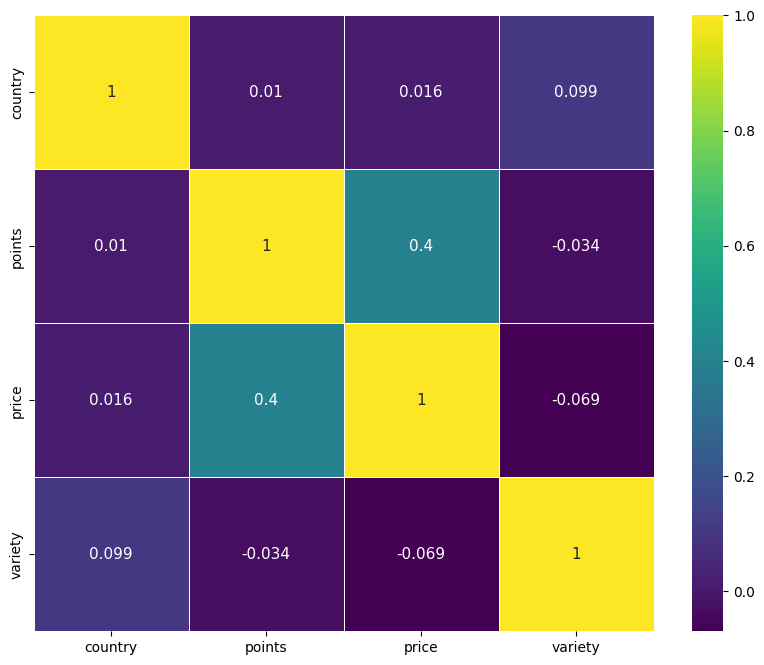

In [15]:
corr = data_scaled.corr()

plt.figure(figsize=(10,8))

sns.heatmap(corr, linewidths=.5, cmap='viridis', annot=True,annot_kws={"size": 11})

По матрице корреляции видно, то между признаками почти отсутствует линейная связь.

In [16]:
from sklearn.decomposition import PCA
pca_2 = PCA(2) # задали количество компонент

pca_2_result = pca_2.fit_transform(data_scaled) 

pca_2_result.shape 

(129907, 2)

И с помощью PCA выделим две главных компоненты для упрощения визуализации

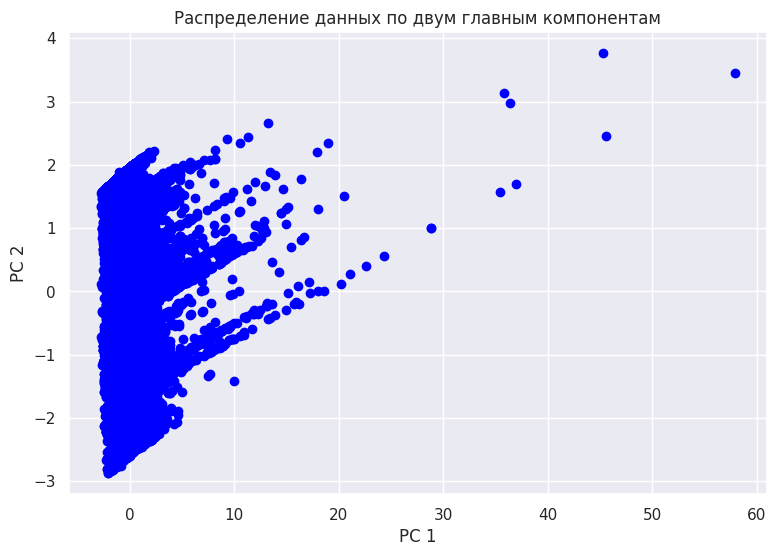

In [ ]:
sns.set(rc={'figure.figsize':(9,6)},font_scale=1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], color='blue') # 0 и 1 - индексы колонок
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.title('Распределение данных по двум главным компонентам')
plt.show()

## Обучение

В качестве алгоритмов кластеризации будут использоваться KMeans и DBSCAN.

In [ ]:

import sklearn.cluster as cluster
kmeans = cluster.KMeans(n_clusters = 2,
               init='k-means++', # метод, как разбросать центры среди данных
               n_init=15, # сколько раз будем переопределять центры (в результате выберем самый успешный)
               max_iter=500, # количество итераций а один проход алгоритма
               random_state=17 # сколько раз датасет перемешан перед кластеризацией
    ) 
    
    
kmeans.fit(data_scaled) # обучаем модель 
print(kmeans.inertia_) # значение инерции для k=2: насколько хорошим было разбиение на 2 кластера

408743.73039155826


In [ ]:
kmeans.fit(data_scaled)
print(kmeans.inertia_)

408743.73039155826


В алгоритме KMeans важным входным параметром является количество групп, на которые разделяются данные. Мы будем перебирать несколько значений и определять наилучшее с помощью метрик инерция и силуэт.

In [ ]:
from sklearn.metrics import silhouette_score

# все как в предыдущей ячейке, только силуэт-скоры сохраняем как значения в словаре
silhouette = {}
for i in tqdm(range(2,20)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(pca_2_result)
    
    silhouette[i] = silhouette_score(pca_2_result, kmeans.labels_, metric='euclidean')



100%|██████████| 18/18 [1:01:37<00:00, 205.41s/it]


In [ ]:
# https://scikit-learn.org/stable/modules/clustering.html#k-means

import sklearn.cluster as cluster

# inertia = {} # сюда будем сохранять значения
inertia = []
for i in tqdm(range(2,20)): # значения интервала - число кластеров (можно изменять) 
    
    kmeans = cluster.KMeans(
               n_clusters=i, # инициализируем модель
               init='k-means++', # метод, как разбросать центры среди данных
               n_init=15, # сколько раз будем переопределять центры (в результате выберем самый успешный)
               max_iter=500, # количество итераций а один проход алгоритма
               random_state=17 # сколько раз датасет перемешан перед кластеризацией
    ) 
    
    
    kmeans.fit(pca_2_result) # обучаем модель 
    inertia.append(kmeans.inertia_) # добавляем значения инерции для каждого числа кластеров
    # inertia.update({i:kmeans.inertia_}) 
    
# print(inertia)

100%|██████████| 18/18 [01:38<00:00,  5.47s/it]


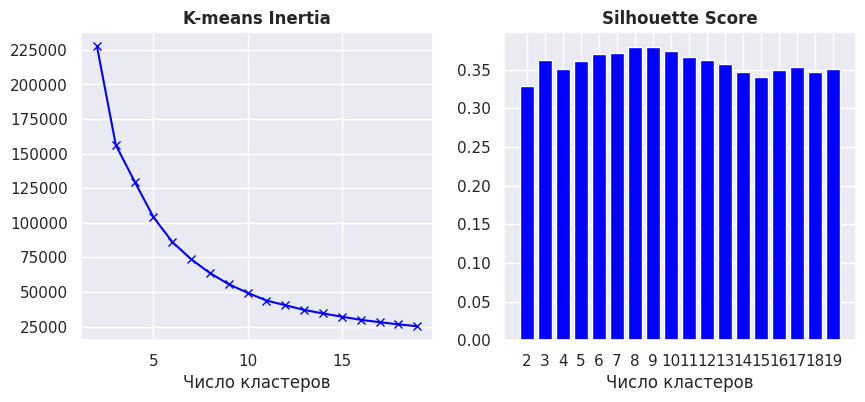

In [ ]:
sns.set(font_scale=1, rc={'figure.figsize':(10,4)})

plt.subplot(1, 2, 1) # аргументы: nrows, ncols, index

plt.plot(range(2,len(inertia)+2), inertia, marker='x',color='blue') 
# первый параметр = x (число шагов= числу кластеров), второй = y (инерция)

plt.xlabel('Число кластеров')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)

plt.subplot(1, 2, 2) # аргументы: nrows, ncols, index

plt.bar(range(len(silhouette)), list(silhouette.values()), align='center',color= 'blue')
plt.xticks(range(len(silhouette)), list(silhouette.keys())) # отметки на шкале
plt.grid(True)
plt.title('Silhouette Score',fontweight='bold')
plt.xlabel('Число кластеров')


plt.show()

Как мы видим по графику наиболее подходящее количество класслв - 9. Так же может подойти 3 класса.

In [ ]:
kmeans = cluster.KMeans(n_clusters=9,random_state=17,init='k-means++')

kmeans_labels = kmeans.fit_predict(pca_2_result)
# вычисляем центры кластеров и предугадываем номер кластера для каждого семпла данных

centroids = kmeans.cluster_centers_

display(pd.Series(kmeans_labels).value_counts()) # кол-во вин по кластерам
# kmeans_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3    26890
1    24994
4    23997
7    19500
2    13277
0    11636
5     9138
8      464
6       11
dtype: int64

In [ ]:
# #  добавим информацию о кластерах в датафрейм
data_scaled['Cluster']=kmeans_labels

pca_2_df = pd.DataFrame(pca_2_result)
pca_2_df['Cluster']=kmeans_labels


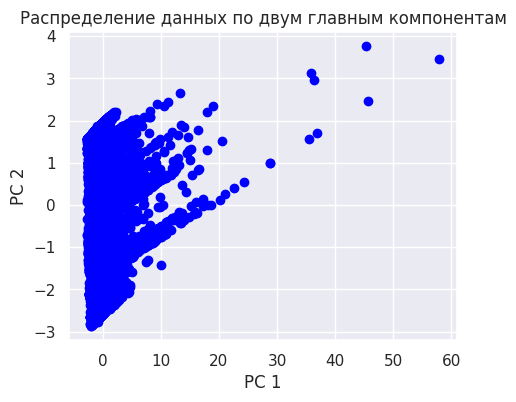

In [ ]:
sns.set(rc={'figure.figsize':(5,4)},font_scale=1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], color='blue') # 0 и 1 - индексы колонок
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.title('Распределение данных по двум главным компонентам')
plt.show()

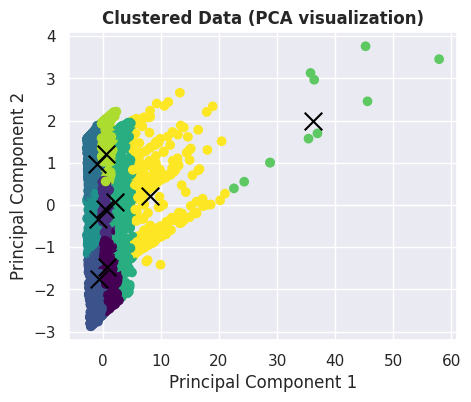

In [ ]:
sns.set( rc={'figure.figsize':(5,4)},font_scale=1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], c=kmeans_labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=160, color='black')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# добавить легенду

plt.title('Clustered Data (PCA visualization)',fontweight='bold')

plt.show()

В целом, мы наблюдаем красивое разделение классов. Такой подход имеет место быть.

Теперь попробуем обучить алгоритм DBSCAN. В нем наиболее важным парметром является eps. Это максимальное расстояние между двумя объектами, при котором один считается соседним с другим.

Ниже я буду перебирать несколько зачений этого параметра и выбирать лучший с помощью силуэта. 

In [17]:
from sklearn.metrics import silhouette_score
import sklearn.cluster as cluster

# все как в предыдущей ячейке, только силуэт-скоры сохраняем как значения в словаре
epses = [0.1, 0.4, 0.7]
silhouette = {}
for i in tqdm(range(len(epses))):
    dbscan = cluster.DBSCAN(eps=epses[i],
               min_samples=15)
    dbscan.fit(pca_2_result)
    
    silhouette[i] = silhouette_score(pca_2_result, dbscan.labels_, metric='euclidean')

100%|██████████| 3/3 [09:05<00:00, 181.97s/it]


In [18]:
silhouette

{0: -0.004371163903230328, 1: 0.7660989267559345, 2: 0.883030397655718}

Получилось, что возможно большее значение параметра eps будет лучше, но на коллабе не получилось обучить и подсчитать метрику из-за большого расхода ОЗУ. Построим кластеризацию и визуализируем со значением eps=0.7

In [19]:
dbscan = cluster.DBSCAN(eps=0.7,
               min_samples=15)

dbscan_labels = dbscan.fit_predict(pca_2_result)
# вычисляем центры кластеров и предугадываем номер кластера для каждого семпла данных

centroids = dbscan.core_sample_indices_

display(pd.Series(dbscan_labels).value_counts()) # кол-во вин по кластерам
# kmeans_labels

 0    129817
-1        90
dtype: int64

In [20]:
# #  добавим информацию о кластерах в датафрейм
data_scaled['Cluster']=dbscan_labels

pca_2_df = pd.DataFrame(pca_2_result)
pca_2_df['Cluster']=dbscan_labels

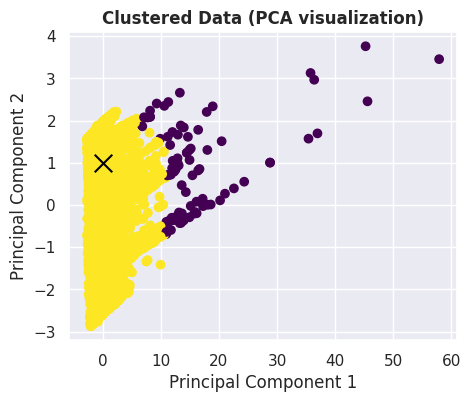

In [22]:
sns.set( rc={'figure.figsize':(5,4)},font_scale=1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], c=dbscan_labels, cmap='viridis')
plt.scatter(centroids[0], centroids[1],
            marker='x', s=160, color='black')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# добавить легенду

plt.title('Clustered Data (PCA visualization)',fontweight='bold')

plt.show()

Разделение на два класса тоже имеет место быть, но результат работы KMeans наверное был более удачным. Возможно для DBSCAN нужно точнее выбрать параметр eps.